In [1]:
import numpy as N
import numpy.random as NR
import pandas
import tqdm
import matplotlib.pyplot as pyplot
import seaborn

seaborn.set_style('whitegrid')

import tqdm
import torch as T
import torch.distributions as TD
import torch.distributions.constraints as TDC
import torch.nn as TN
import torch.nn.functional as TNF
import pyro as P
import pyro.infer as PI
import pyro.optim as PO
import pyro.distributions as PD
import pyro.nn as PN

P.set_rng_seed(0)

In [2]:
import sys
sys.path.append('..')
sys.path.append('../..')
import igg
import model
import guide

In [3]:
def draw():
    replicate = False
    if replicate:
        x = NR.binomial(1, 0.5, (12,))
        obs = NR.normal(N.where(x, -5, 5), 1.0)
    else:
        obs = NR.normal(0.0, 4.0, (12,))
    return T.tensor(obs.astype('float32'))
def plated_model(obs):
    for i in P.plate("data_loop", len(obs)):
        model.model(i, obs[i])
def plated_guide(obs):
    for i in P.plate("data_loop", len(obs)):
        guide.model(i, obs[i])

  0%|          | 0/2500 [00:00<?, ?it/s]/data/examples/02_if_plate/guide.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return T.tensor(obs)
/data/examples/02_if_plate/guide.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return T.tensor(obs)
/data/examples/02_if_plate/model.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return P.sample(f"obs_{i}", PD.Normal(y, 0.1), obs=T.tensor(obs))
/data/examples/02_if_plate/model.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach

<AxesSubplot:xlabel='step', ylabel='loss'>

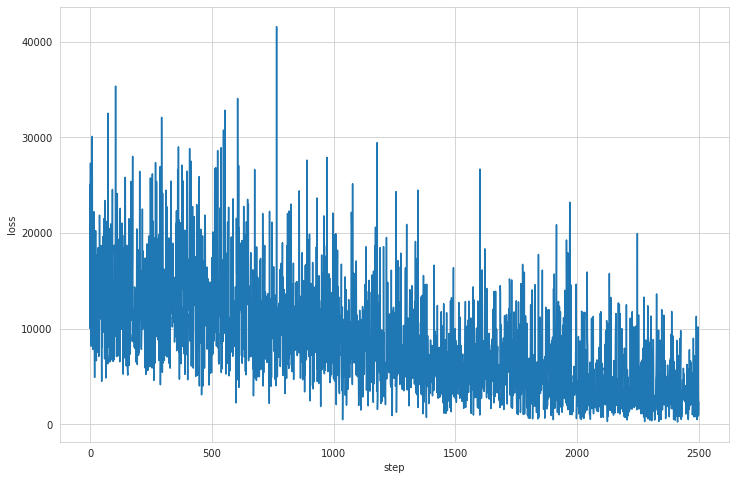

In [4]:
P.clear_param_store()
svi = PI.SVI(model=plated_model,
            guide=plated_guide,
            optim=PO.Adam({"lr": 0.001}),
             loss=PI.Trace_ELBO()
            )
hist = pandas.DataFrame(columns=["step", "loss"])
for step in tqdm.trange(2500):
    obs = draw()
    loss = svi.step(obs)
    hist = hist.append({
        "step": step,
        "loss": loss,
    }, ignore_index=True)

fig, ax = pyplot.subplots(figsize=(12,8))
seaborn.lineplot(x="step", y="loss", data=hist, ax=ax)